(DEMetropolis_comparisons)=
# DEMetropolis and DEMetropolis(Z) Algorithm Comparisons
:::{post} January 18, 2023
:tags: DEMetropolis, gradient-free inference
:category: intermediate, how-to
:author: Michael Osthege, Greg Brunkhorst
:::

In [1]:
import time

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import scipy.stats as st

print(f"Running on PyMC v{pm.__version__}")

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC v0+untagged.9358.g8ea092d


In [2]:
az.style.use("arviz-darkgrid")
rng = np.random.default_rng(1234)

## Background
For continuous variables, the default PyMC sampler (`NUTS`) requires that gradients are computed, which PyMC does through autodifferentiation.  However, in some cases, a PyMC model may not be supplied with gradients (for example, by evaluating a numerical model outside of PyMC) and an alternative sampler is necessary.  Differential evolution (DE) Metropolis samplers are an efficient choice for gradient-free inference.  This notebook compares the `DEMetropolis` and the `DEMetropolisZ` samplers in PyMC to help determine which is a better option for a given problem. 

The samplers are based on {cite:t}`terBraak2006markov` and {cite:t}`terBraak2008differential` and are described in the notebook [DEMetropolis(Z) Sampler Tuning](DEMetropolisZ_sampler_tuning).  The idea behind differential evolution is to use randomly selected draws from other chains (DEMetropolis), or from past draws of the current chain (DEMetropolis(Z)), to make more educated proposals, thus improving sampling efficiency over the standard Metropolis implementation. Note that the PyMC implementation of `DEMetropolisZ` is slightly different than in {cite:t}`terBraak2008differential`, namely, each `DEMetropolisZ` chain only looks into its own history, whereas the {cite:t}`terBraak2008differential` algorithm has some mixing across chains.



In this notebook, 10 and 50-dimensional multivariate normal target densities will be sampled with both `DEMetropolis` and `DEMetropolisZ` samplers.  Samplers will be evaluated based on effective sample size, sampling time and MCMC chain correlation $(\hat{R})$.  Samplers will also be compared to `NUTS` for benchmarking.  Finally, MCMC traces will be compared to the analytically calculated target probability densities to assess potential bias in high dimensions.  

## Key Take-Aways (TL;DR)
Based on the results in this notebook, use `DEMetropolisZ` for lower dimensional problems ($\approx10D$), and `DEMetropolis` for higher dimensional problems ($\approx50D$)
* The `DEMetropolisZ` sampler was more efficient (ESS per second sampling) than `DEMetropolis`.
* The `DEMetropolisZ` sampler had better chain convergence $(\hat{R})$ than `DEMetropolis`.
* Bias was evident in the `DEMetropolisZ` sampler at 50 dimensions, resulting in reduced variance compared to the target distribution.  `DEMetropolis` more accurately sampled the high dimensional target distribution, using $2D$ chains (twice the number of model parameters).  
* As expected, `NUTS` was more efficient and accurate than either Metropolis-based algorithms.    

## Helper Functions
This section defines helper functions that will be used throughout the notebook.  

### D-dimensional MvNormal Target Distribution and PyMC Model
`gen_mvnormal_params` generates the parameters for the target distribution, which is a multivariate normal distribution with $\sigma^2$ = `[1, 2, 3, 4, 5]` in the first five dimensions and some correlation thrown in.

In [3]:
def gen_mvnormal_params(D):
    # means=zero
    mu = np.zeros(D)
    # sigma**2 = 1 to start
    cov = np.eye(D)
    # manually adjust the first 5 dimensions
    # sigma**2 in the first 5 dimensions = 1, 2, 3, 4, 5
    # with a little covariance added
    cov[:5, :5] = np.array(
        [
            [1, 0.5, 0, 0, 0],
            [0.5, 2, 2, 0, 0],
            [0, 2, 3, 0, 0],
            [0, 0, 0, 4, 4],
            [0, 0, 0, 4, 5],
        ]
    )
    return mu, cov

`make_model` accepts the multivariate normal parameters `mu` and `cov` and outputs a PyMC model.     

In [4]:
def make_model(mu, cov):
    with pm.Model() as model:
        x = pm.MvNormal("x", mu=mu, cov=cov, shape=(len(mu),))
    return model

### Sampling
`sample_model` performs MCMC, returns the trace and the sampling duration.  

In [5]:
def sample_model(
    model, D, run=0, step_class=pm.DEMetropolis, cores=1, chains=1, step_kwargs={}, sample_kwargs={}
):
    # sampler name
    sampler = step_class.name
    # sample model

    # if nuts then do not provide step method
    if sampler == "nuts":
        with model:
            step = step_class(**step_kwargs)
            t_start = time.time()
            idata = pm.sample(
                # step=step,
                chains=chains,
                cores=cores,
                initvals={"x": [0] * D},
                discard_tuned_samples=False,
                progressbar=False,
                random_seed=2020 + run,
                **sample_kwargs
            )
            t = time.time() - t_start

    # signature for DEMetropolis samplers
    else:
        with model:
            step = step_class(**step_kwargs)
            t_start = time.time()
            idata = pm.sample(
                step=step,
                chains=chains,
                cores=cores,
                initvals={"x": [0] * D},
                discard_tuned_samples=False,
                progressbar=False,
                random_seed=2020 + run,
                **sample_kwargs
            )
            t = time.time() - t_start

    return idata, t

`calc_mean_ess` calculates the mean ess for the dimensions of the distribution.

In [6]:
def calc_mean_ess(idata):
    return az.ess(idata).x.values.mean()

`calc_mean_rhat` calculates the mean $\hat{R}$ for the dimensions of the distribution.

In [7]:
def calc_mean_rhat(idata):
    return az.rhat(idata).x.values.mean()

`sample_model_calc_metrics` wraps the previously defined functions: samples the model, calculates the metrics and packages the results in a Pandas `DataFrame`

In [8]:
def sample_model_calc_metrics(
    sampler,
    D,
    tune,
    draws,
    cores=1,
    chains=1,
    run=0,
    step_kwargs=dict(proposal_dist=pm.NormalProposal, tune="scaling"),
    sample_kwargs={},
):
    mu, cov = gen_mvnormal_params(D)
    model = make_model(mu, cov)
    idata, t = sample_model(
        model,
        D,
        step_class=sampler,
        cores=cores,
        chains=chains,
        run=run,
        step_kwargs=step_kwargs,
        sample_kwargs=dict(sample_kwargs, **dict(tune=tune, draws=draws)),
    )
    ess = calc_mean_ess(idata)
    rhat = calc_mean_rhat(idata)
    results = dict(
        Sampler=sampler.__name__,
        D=D,
        Chains=chains,
        Cores=cores,
        tune=tune,
        draws=draws,
        ESS=ess,
        Time_sec=t,
        ESSperSec=ess / t,
        rhat=rhat,
        Trace=[idata],
    )
    return pd.DataFrame(results)

`concat_results` concatenates the results and does a some data wrangling and calculating.  

In [9]:
def concat_results(results):
    results_df = pd.concat(results)

    results_df["Run"] = results_df.Sampler + "\nChains=" + results_df.Chains.astype(str)

    results_df["ESS_pct"] = results_df.ESS * 100 / (results_df.Chains * results_df.draws)
    return results_df

### Plotting

`plot_comparison_bars` plots the ESS and $\hat{R}$ results for comparison.  

In [10]:
def plot_comparison_bars(results_df):
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))
    ax = axes[0]
    results_df.plot.bar(y="ESSperSec", x="Run", ax=ax, legend=False)
    ax.set_title("ESS per Second")
    ax.set_xlabel("")
    labels = ax.get_xticklabels()

    ax = axes[1]
    results_df.plot.bar(y="ESS_pct", x="Run", ax=ax, legend=False)
    ax.set_title("ESS Percentage")
    ax.set_xlabel("")
    labels = ax.get_xticklabels()

    ax = axes[2]
    results_df.plot.bar(y="rhat", x="Run", ax=ax, legend=False)
    ax.set_title(r"$\hat{R}$")
    ax.set_xlabel("")
    ax.set_ylim(1)
    labels = ax.get_xticklabels()

    plt.suptitle(f"Comparison of Runs for {D} Dimensional Target Distribution", fontsize=16)
    plt.tight_layout()

`plot_forest_compare_analytical` plots the MCMC results for the first 5 dimensions and compares to the analytically calculated probability density.   

In [11]:
def plot_forest_compare_analytical(results_df):
    # extract the first 5 dimensions
    summaries = []
    truncated_traces = []
    dimensions = 5
    for row in results_df.index:
        truncated_trace = results_df.Trace.loc[row].posterior.x[:, :, :dimensions]
        truncated_traces.append(truncated_trace)
        summary = az.summary(truncated_trace)
        summary["Run"] = results_df.at[row, "Run"]
        summaries.append(summary)
    summaries = pd.concat(summaries)

    # plot forest
    axes = az.plot_forest(
        truncated_traces, combined=True, figsize=(8, 3), model_names=results_df.Run
    )
    ax = axes[0]

    # plot analytical solution
    yticklabels = ax.get_yticklabels()
    yticklocs = [tick.__dict__["_y"] for tick in yticklabels]
    min, max = axes[0].get_ylim()
    width = (max - min) / 6
    mins = [ytickloc - (width / 2) for ytickloc in yticklocs]
    maxes = [ytickloc + (width / 2) for ytickloc in yticklocs]
    sigmas = [np.sqrt(sigma2) for sigma2 in range(1, 6)]
    for i, (sigma, min, max) in enumerate(zip(sigmas, mins[::-1], maxes[::-1])):
        # scipy.stats.norm to calculate analytical marginal distribution
        dist = st.norm(0, sigma)
        ax.vlines(dist.ppf(0.03), min, max, color="black", linestyle=":")
        ax.vlines(dist.ppf(0.97), min, max, color="black", linestyle=":")
        ax.vlines(dist.ppf(0.25), min, max, color="black", linestyle=":")
        ax.vlines(dist.ppf(0.75), min, max, color="black", linestyle=":")
        if i == 0:
            ax.text(dist.ppf(0.97) + 0.2, min, "Analytical Solutions\n(Dotted)", fontsize=8)

    # legend
    labels = ax.get_legend().__dict__["texts"]
    labels = [label.__dict__["_text"] for label in labels]
    handles = ax.get_legend().__dict__["legendHandles"]
    ax.legend(
        handles[::-1],
        labels[::-1],
        loc="center left",
        bbox_to_anchor=(1, 0.5),
        fontsize="medium",
        fancybox=True,
        title="94% and 50% HDI",
    )
    ax.set_title(
        f"Comparison of MCMC Samples and Analytical Solutions\nFirst 5 Dimensions of {D} Dimensional Target Distribution"
    )

`plot_forest_compare_analytical_dim5` plots the MCMC results for the fift 5 dimension and compares to the analytically calculated probability density for repeated runs for the bias check.   

In [12]:
def plot_forest_compare_analytical_dim5(results_df):
    # extract the 5th dimension
    summaries = []
    truncated_traces = []
    dimension_idx = 4
    for row in results_df.index:
        truncated_trace = results_df.Trace.loc[row].posterior.x[:, :, dimension_idx]
        truncated_traces.append(truncated_trace)
        summary = az.summary(truncated_trace)
        summary["Sampler"] = results_df.at[row, "Sampler"]
        summaries.append(summary)
    summaries = pd.concat(summaries)
    cols = ["Sampler", "mean", "sd", "hdi_3%", "hdi_97%", "ess_bulk", "ess_tail", "r_hat"]
    summary_means = summaries[cols].groupby("Sampler").mean()

    # scipy.stats.norm to calculate analytical marginal distribution
    dist = st.norm(0, np.sqrt(5))
    summary_means.at["Analytical", "mean"] = 0
    summary_means.at["Analytical", "sd"] = np.sqrt(5)
    summary_means.at["Analytical", "hdi_3%"] = dist.ppf(0.03)
    summary_means.at["Analytical", "hdi_97%"] = dist.ppf(0.97)

    # plot forest
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    axes = az.plot_forest(
        truncated_traces,
        combined=True,
        figsize=(8, 3),
        colors=[colors[0]] * reps + [colors[1]] * reps + [colors[2]] * reps,
        model_names=results_df.Sampler,
    )
    ax = axes[0]

    # legend
    labels = ax.get_legend().__dict__["texts"]
    labels = [label.__dict__["_text"] for label in labels]
    handles = ax.get_legend().__dict__["legendHandles"]
    labels = [labels[reps - 1]] + [labels[reps * 2 - 1]] + [labels[reps * 3 - 1]]
    handles = [handles[reps - 1]] + [handles[reps * 2 - 1]] + [handles[reps * 3 - 1]]
    ax.legend(
        handles[::-1],
        labels[::-1],
        loc="center left",
        bbox_to_anchor=(1, 0.5),
        fontsize="medium",
        fancybox=True,
        title="94% and 50% HDI",
    )
    ax.set_title(
        f"Comparison of MCMC Samples and Analytical Solutions\n5th Dimension of {D} Dimensional Target Distribution"
    )

    # plot analytical solution as vlines
    ax.axvline(dist.ppf(0.03), color="black", linestyle=":")
    ax.axvline(dist.ppf(0.97), color="black", linestyle=":")
    ax.text(dist.ppf(0.97) + 0.1, 0, "Analytical Solution\n(Dotted)", fontsize=8)
    return summaries, summary_means

## Experiment #1.  10-Dimensional Target Distribution

All traces are sampled with `cores=1`.  Surprisingly, sampling was slower using multiple cores rather than one core for both samplers for the same number of total samples.

`DEMetropolisZ` and `NUTS` are sampled with four chains, and `DEMetropolis` are sampled with more based on {cite:t}`terBraak2008differential`.  `DEMetropolis` requires that, at a minimum, $N$ chains are larger than $D$ dimensions.  However, {cite:t}terBraak2008differential recommends that $2D<N<3D$ for $D<50$, and $10D<N<20D$ for higher dimensional problems or complicated posteriors.  

The following code lays out the runs for this experiment.  

In [13]:
# dimensions
D = 10
# total samples are constant for Metropolis algorithms
total_samples = 200000
samplers = [pm.DEMetropolisZ] + [pm.DEMetropolis] * 3 + [pm.NUTS]
coreses = [1] * 5
chainses = [4, 1 * D, 2 * D, 3 * D, 4]
# calculate the number of tunes and draws for each run
tunes = drawses = [int(total_samples / chains) for chains in chainses]
# manually adjust NUTs, which needs fewer samples
tunes[-1] = drawses[-1] = 2000
# put it in a dataframe for display and QA/QC
pd.DataFrame(
    dict(
        sampler=[s.name for s in samplers],
        tune=tunes,
        draws=drawses,
        chains=chainses,
        cores=coreses,
    )
).style.set_caption("MCMC Runs for 10-Dimensional Experiment")

,sampler,tune,draws,chains,cores
0,DEMetropolisZ,50000,50000,4,1
1,DEMetropolis,20000,20000,10,1
2,DEMetropolis,10000,10000,20,1
3,DEMetropolis,6666,6666,30,1
4,nuts,2000,2000,4,1


In [14]:
results = []
run = 0
for sampler, tune, draws, cores, chains in zip(samplers, tunes, drawses, coreses, chainses):
    if sampler.name == "nuts":
        results.append(
            sample_model_calc_metrics(
                sampler, D, tune, draws, cores=cores, chains=chains, run=run, step_kwargs={}
            )
        )
    else:
        results.append(
            sample_model_calc_metrics(sampler, D, tune, draws, cores=cores, chains=chains, run=run)
        )
    run += 1

Sequential sampling (4 chains in 1 job)
DEMetropolisZ: [x]
Sampling 4 chains for 50_000 tune and 50_000 draw iterations (200_000 + 200_000 draws total) took 123 seconds.
Population sampling (10 chains)
DEMetropolis: [x]
C:\Users\greg\Documents\CodingProjects_ongoing\pymc\pymc\pymc\sampling\population.py:84: UserWarning: DEMetropolis should be used with more chains than dimensions! (The model has 10 dimensions.)
  warn_population_size(
Chains are not parallelized. You can enable this by passing `pm.sample(cores=n)`, where n > 1.
Sampling 10 chains for 20_000 tune and 20_000 draw iterations (200_000 + 200_000 draws total) took 142 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Population s

In [15]:
results_df = concat_results(results)
results_df = results_df.reset_index(drop=True)
cols = results_df.columns
results_df[cols[~cols.isin(["Trace", "Run"])]].round(2).style.set_caption(
    "Results of MCMC Sampling of 10-Dimensional Target Distribution"
)

,Sampler,D,Chains,Cores,tune,draws,ESS,Time_sec,ESSperSec,rhat,ESS_pct
0,DEMetropolisZ,10,4,1,50000,50000,6296.480000,127.650000,49.330000,1.000000,3.150000
1,DEMetropolis,10,10,1,20000,20000,3492.280000,147.460000,23.680000,1.000000,1.750000
2,DEMetropolis,10,20,1,10000,10000,5537.930000,156.310000,35.430000,1.000000,2.770000
3,DEMetropolis,10,30,1,6666,6666,5657.900000,166.250000,34.030000,1.010000,2.830000
4,NUTS,10,4,1,2000,2000,7731.260000,72.360000,106.850000,1.000000,96.640000


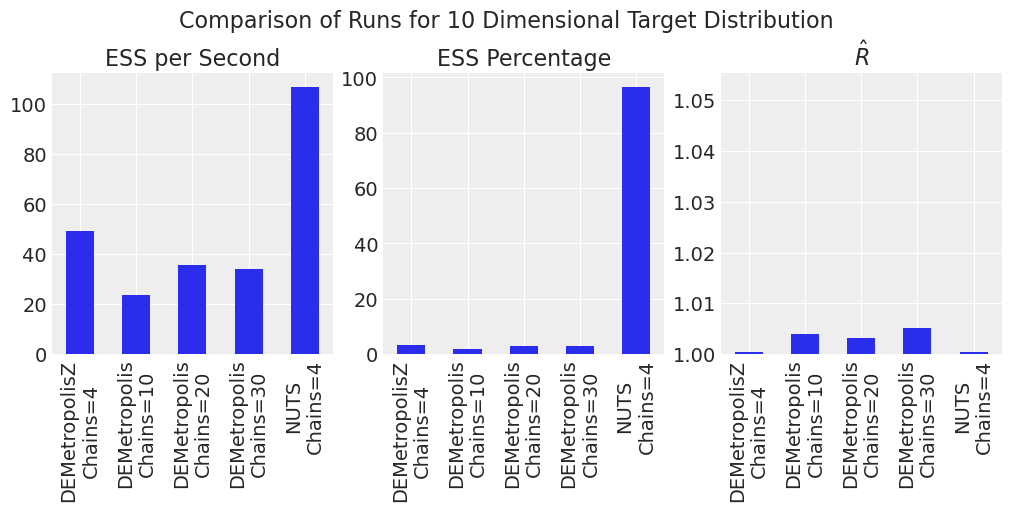

In [16]:
plot_comparison_bars(results_df)

`NUTs` is the most efficient.  `DEMetropolisZ` is more efficient and has lower $\hat{R}$ than `DEMetropolis`.    

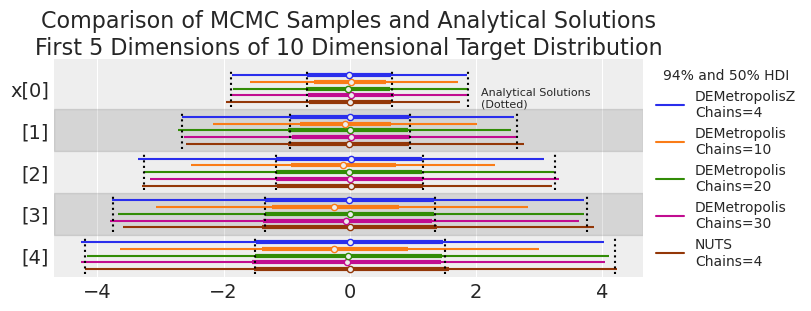

In [17]:
plot_forest_compare_analytical(results_df)

Based on the visual check, the traces have reasonably converged on the target distribution, with the exception of `DEMetropolis` at 10 chains, supporting the suggestion that the number of chains should be at least 2 times the number of dimensions for a 10 dimensional problem.      

## Experiment #2.  50-Dimensional Target Distribution
Let's repeat in 50-dimensions but with even more chains for the `DEMetropolis` algorithm.    

In [18]:
# dimensions
D = 50
# total samples are constant for Metropolis algorithms
total_samples = 200000
samplers = [pm.DEMetropolisZ] + [pm.DEMetropolis] * 3 + [pm.NUTS]
coreses = [1] * 5
chainses = [4, 2 * D, 10 * D, 20 * D, 4]
# calculate the number of tunes and draws for each run
tunes = drawses = [int(total_samples / chains) for chains in chainses]
# manually adjust NUTs, which needs fewer samples
tunes[-1] = drawses[-1] = 2000
# put it in a dataframe for display and QA/QC
pd.DataFrame(
    dict(
        sampler=[s.name for s in samplers],
        tune=tunes,
        draws=drawses,
        chains=chainses,
        cores=coreses,
    )
).style.set_caption("MCMC Runs for 50-Dimensional Experiment")

,sampler,tune,draws,chains,cores
0,DEMetropolisZ,50000,50000,4,1
1,DEMetropolis,2000,2000,100,1
2,DEMetropolis,400,400,500,1
3,DEMetropolis,200,200,1000,1
4,nuts,2000,2000,4,1


In [19]:
results = []
run = 0
for sampler, tune, draws, cores, chains in zip(samplers, tunes, drawses, coreses, chainses):
    if sampler.name == "nuts":
        results.append(
            sample_model_calc_metrics(
                sampler,
                D,
                tune,
                draws,
                cores=cores,
                chains=chains,
                run=run,
                step_kwargs={},
                sample_kwargs=dict(nuts=dict(target_accept=0.95)),
            )
        )
    else:
        results.append(
            sample_model_calc_metrics(sampler, D, tune, draws, cores=cores, chains=chains, run=run)
        )
    run += 1

Sequential sampling (4 chains in 1 job)
DEMetropolisZ: [x]
Sampling 4 chains for 50_000 tune and 50_000 draw iterations (200_000 + 200_000 draws total) took 148 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Population sampling (100 chains)
DEMetropolis: [x]
Chains are not parallelized. You can enable this by passing `pm.sample(cores=n)`, where n > 1.
Sampling 100 chains for 2_000 tune and 2_000 draw iterations (200_000 + 200_000 draws total) took 185 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Only 400 samples in chain.
Population sampling (500 chains)
DEMetropolis: [x]
Cha

In [20]:
results_df = concat_results(results)
results_df = results_df.reset_index(drop=True)
cols = results_df.columns
results_df[cols[~cols.isin(["Trace", "Run"])]].round(2).style.set_caption(
    "Results of MCMC Sampling of 50-Dimensional Target Distribution"
)

,Sampler,D,Chains,Cores,tune,draws,ESS,Time_sec,ESSperSec,rhat,ESS_pct
0,DEMetropolisZ,50,4,1,50000,50000,1309.830000,163.870000,7.990000,1.000000,0.650000
1,DEMetropolis,50,100,1,2000,2000,792.730000,236.830000,3.350000,1.090000,0.400000
2,DEMetropolis,50,500,1,400,400,1083.880000,415.260000,2.610000,1.410000,0.540000
3,DEMetropolis,50,1000,1,200,200,1616.890000,633.760000,2.550000,1.710000,0.810000
4,NUTS,50,4,1,2000,2000,10570.020000,105.300000,100.380000,1.000000,132.130000


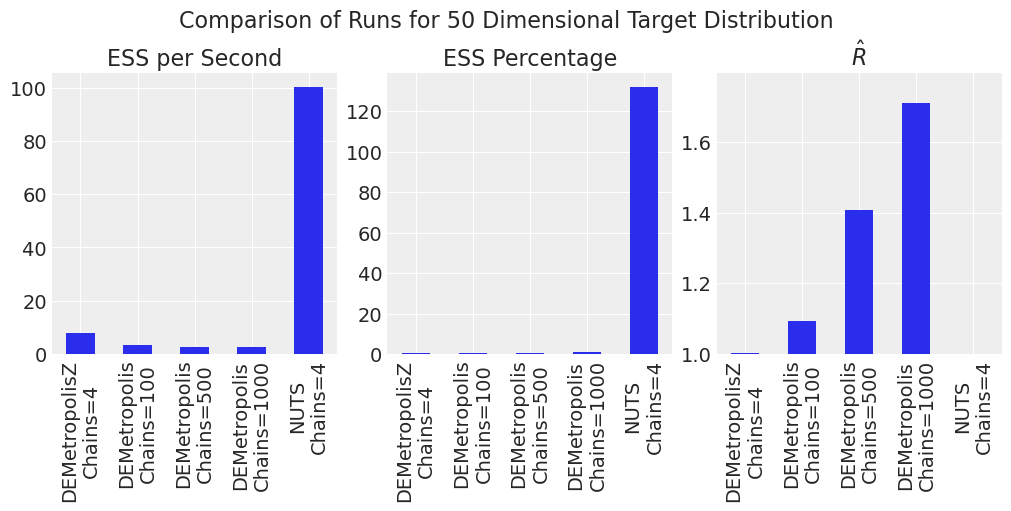

In [21]:
plot_comparison_bars(results_df)

The efficiency advantage for `NUTS` over `DEMetropolisZ` over `DEMetropolis` is more pronounced in higher dimensions.  $\hat{R}$ is also large for `DEMetropolis` for this sample size and number of chains.  For `DEMetropolis`, a smaller number of chains ($2N$) with a larger number of samples performed better than more chains with fewer samples.  Counter-intuitively, the `NUTS` sampler yeilds $ESS$ values greater than the number of samples, which can occur as discussed [here](https://discourse.pymc.io/t/effective-sample-size-larger-than-number-of-samples-for-nuts/6275).

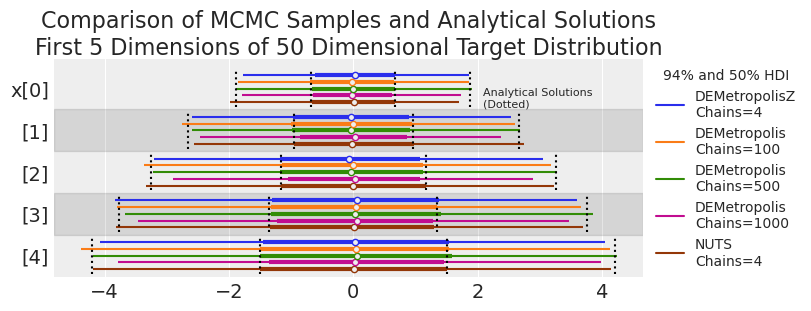

In [22]:
plot_forest_compare_analytical(results_df)

We might be seeing low coverage in the tails of some `DEMetropolis` runs (i.e., the MCMC HDIs are consistently smaller than the analytical solution).  Let's explore this more systematically in the next experiment.    

## Experiment #3. Accuracy and Bias
We want to make sure that the `DEMetropolis` samplers are providing coverage for high dimensional problems (i.e., the tails are appropriately sampled).  We will test for bias by running the algorithm multiple times and comparing to both `NUTS` and the analytically-calculated probability density.  We will perform MCMC in many dimensions but analyze the results for the dimension with the most variance (dimension 5) for simplicity.    

### 10 Dimensions
First check in 10 dimensions.  We will perform 10 replicates for each run.  `DEMetropolis` will be run at $2D$ chains.  The number of tunes and draws have been tailored to get effective sampler sizes of greater than 2000.  

In [23]:
D = 10
reps = 10
samplers = [pm.DEMetropolis] * reps + [pm.DEMetropolisZ] * reps + [pm.NUTS] * reps
coreses = [1] * reps * 3
chainses = [2 * D] * reps + [4] * reps * 2
tunes = drawses = [5000] * reps + [25000] * reps + [1000] * reps

results = []
run = 0
for sampler, tune, draws, cores, chains in zip(samplers, tunes, drawses, coreses, chainses):
    if sampler.name == "nuts":
        results.append(
            sample_model_calc_metrics(
                sampler,
                D,
                tune,
                draws,
                cores=cores,
                chains=chains,
                run=run,
                step_kwargs={},
                sample_kwargs=dict(target_accept=0.95),
            )
        )
    else:
        results.append(
            sample_model_calc_metrics(sampler, D, tune, draws, cores=cores, chains=chains, run=run)
        )
    run += 1

Population sampling (20 chains)
DEMetropolis: [x]
Chains are not parallelized. You can enable this by passing `pm.sample(cores=n)`, where n > 1.
Sampling 20 chains for 5_000 tune and 5_000 draw iterations (100_000 + 100_000 draws total) took 92 seconds.
Population sampling (20 chains)
DEMetropolis: [x]
Chains are not parallelized. You can enable this by passing `pm.sample(cores=n)`, where n > 1.
Sampling 20 chains for 5_000 tune and 5_000 draw iterations (100_000 + 100_000 draws total) took 81 seconds.
Population sampling (20 chains)
DEMetropolis: [x]
Chains are not parallelized. You can enable this by passing `pm.sample(cores=n)`, where n > 1.
Sampling 20 chains for 5_000 tune and 5_000 draw iterations (100_000 + 100_000 draws total) took 81 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Population sampling (20 chains)
DEMetropolis: [x]
Chains are not parallelized. You can e

,mean,sd,hdi_3%,hdi_97%,ess_bulk,ess_tail,r_hat
Sampler,,,,,,,
DEMetropolis,-0.021700,2.214500,-4.125400,4.174200,2772.400000,5331.700000,1.010000
DEMetropolisZ,-0.000200,2.226000,-4.188600,4.159800,3089.100000,5587.200000,1.000000
NUTS,0.001400,2.257800,-4.252700,4.196400,2618.100000,2798.000000,1.000000
Analytical,0.000000,2.236068,-4.205582,4.205582,nan,nan,nan


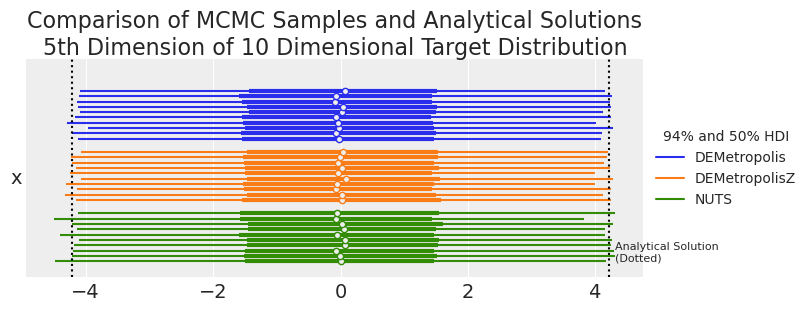

In [24]:
results_df = concat_results(results)
results_df = results_df.reset_index(drop=True)
summaries, summary_means = plot_forest_compare_analytical_dim5(results_df)
summary_means.style.set_caption(
    "MCMC and Analytical Results for 5th Dimension of 10 Dimensional Target Distribution"
)

Visually, `DEMetropolis` algorithms look as reasonable accurate and as accurate as `NUTS`.  Since we have 10 replicates that we want to compare to the analytical solution, we can dust off our traditional statistics and perform an old-school one-sided t-test to see if the sampler-calculated confidence limits are significantly different than the analytically calculated confidence limit.  

In [25]:
samplers = ["DEMetropolis", "DEMetropolisZ", "NUTS"]
cls_str = ["hdi_3%", "hdi_97%"]
cls_val = [0.03, 0.97]
dist = st.norm(0, np.sqrt(5))
results = []
for sampler in samplers:
    for cl_str, cl_val in zip(cls_str, cls_val):
        mask = summaries.Sampler == sampler
        # collect the credible limits for each MCMC run
        mcmc_cls = summaries.loc[mask, cl_str]

        # calculate the confidence limit for the target dist
        analytical_cl = dist.ppf(cl_val)

        # one sided t-test!
        p_value = st.ttest_1samp(mcmc_cls, analytical_cl).pvalue
        results.append(
            pd.DataFrame(dict(Sampler=[sampler], ConfidenceLimit=[cl_str], Pvalue=[p_value]))
        )
pd.concat(results).style.set_caption(
    "MCMC Replicates Compared to Analytical Solution for Selected Confidence Limits"
)

,Sampler,ConfidenceLimit,Pvalue
0,DEMetropolis,hdi_3%,0.018270
0,DEMetropolis,hdi_97%,0.307391
0,DEMetropolisZ,hdi_3%,0.555155
0,DEMetropolisZ,hdi_97%,0.177881
0,NUTS,hdi_3%,0.336053
0,NUTS,hdi_97%,0.847152


A higher p-value indicates that the MCMC algorithm captures the analytical value with high confidence.  A lower p-value means that the MCMC algorithm was unexpectedly high or low compared to the analytically calculated confidence limit.  The `NUTS` sampler is capturing the analytically calculated value with high confidence.  The `DEMetropolis` algorithms have lower confidence but are giving reasonable results.    

### 50 Dimensions
Higher dimensions get increasingly difficult for Metropolis algorithms.  Here we will sample with very large sample sizes (this will take a while) to get at least 2000 effective samples.  

In [26]:
D = 50
reps = 10
samplers = [pm.DEMetropolis] * reps + [pm.DEMetropolisZ] * reps + [pm.NUTS] * reps
coreses = [1] * reps * 3
chainses = [2 * D] * reps + [4] * reps * 2
tunes = drawses = [5000] * reps + [100000] * reps + [1000] * reps

results = []
run = 0
for sampler, tune, draws, cores, chains in zip(samplers, tunes, drawses, coreses, chainses):
    if sampler.name == "nuts":
        results.append(
            sample_model_calc_metrics(
                sampler,
                D,
                tune,
                draws,
                cores=cores,
                chains=chains,
                run=run,
                step_kwargs={},
                sample_kwargs=dict(target_accept=0.95),
            )
        )
    else:
        results.append(
            sample_model_calc_metrics(sampler, D, tune, draws, cores=cores, chains=chains, run=run)
        )
    run += 1

results_df = concat_results(results)
results_df = results_df.reset_index(drop=True)

Population sampling (100 chains)
DEMetropolis: [x]
Chains are not parallelized. You can enable this by passing `pm.sample(cores=n)`, where n > 1.
Sampling 100 chains for 5_000 tune and 5_000 draw iterations (500_000 + 500_000 draws total) took 459 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Population sampling (100 chains)
DEMetropolis: [x]
Chains are not parallelized. You can enable this by passing `pm.sample(cores=n)`, where n > 1.
Sampling 100 chains for 5_000 tune and 5_000 draw iterations (500_000 + 500_000 draws total) took 471 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for de

,mean,sd,hdi_3%,hdi_97%,ess_bulk,ess_tail,r_hat
Sampler,,,,,,,
DEMetropolis,-0.007700,2.236900,-4.224400,4.178500,2583.200000,5619.600000,1.034000
DEMetropolisZ,-0.009700,2.172500,-4.088500,4.079600,2616.800000,5408.700000,1.000000
NUTS,0.030000,2.244200,-4.235000,4.144900,2552.600000,2811.200000,1.000000
Analytical,0.000000,2.236068,-4.205582,4.205582,nan,nan,nan


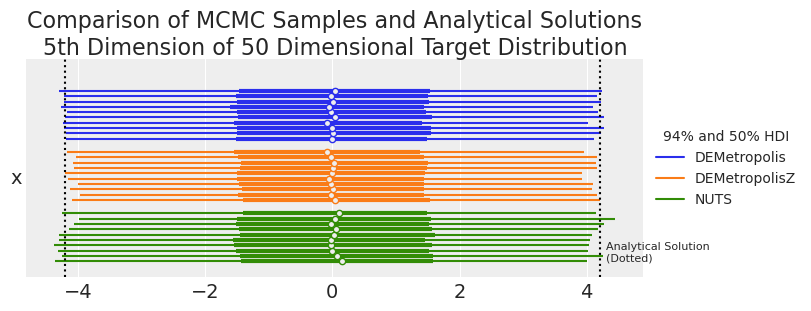

In [27]:
summaries, summary_means = plot_forest_compare_analytical_dim5(results_df)
summary_means.style.set_caption(
    "MCMC and Analytical Results for 5th Dimension of 50 Dimensional Target Distribution"
)

In [28]:
samplers = ["DEMetropolis", "DEMetropolisZ", "NUTS"]
cls_str = ["hdi_3%", "hdi_97%"]
cls_val = [0.03, 0.97]
results = []
for sampler in samplers:
    for cl_str, cl_val in zip(cls_str, cls_val):
        mask = summaries.Sampler == sampler

        # collect the credible limits for each MCMC run
        mcmc_cls = summaries.loc[mask, cl_str]

        # calculate the confidence limit for the target dist
        analytical_cl = dist.ppf(cl_val)

        # one sided t-test!
        p_value = st.ttest_1samp(mcmc_cls, analytical_cl).pvalue

        results.append(
            pd.DataFrame(dict(Sampler=[sampler], ConfidenceLimit=[cl_str], Pvalue=[p_value]))
        )
pd.concat(results).style.set_caption(
    "MCMC Replicates Compared to Analytical Solution for Selected Confidence Limits"
)

,Sampler,ConfidenceLimit,Pvalue
0,DEMetropolis,hdi_3%,0.152028
0,DEMetropolis,hdi_97%,0.318463
0,DEMetropolisZ,hdi_3%,0.001217
0,DEMetropolisZ,hdi_97%,0.005154
0,NUTS,hdi_3%,0.490542
0,NUTS,hdi_97%,0.212516


We can see that at 50 dimensions, the `DEMetropolisZ` sampler has poor coverage compared to `DEMetropolis`.  Therefore, even though `DEMetropolisZ` is more efficient and has lower $\hat{R}$ values than `DEMetropolis`, `DEMetropolis` is suggested for higher dimensional problems.     

## Conclusion
Based on the results in this notebook, if you cannot use `NUTS`, use `DEMetropolisZ` for lower dimensional problems (e.g., $10D$) because it is more efficient and converges better.  Use `DEMetropolis` for higher dimensional problems (e.g., $50D$) to better capture the tails of the target distribution.  

In [29]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Fri Feb 10 2023

Python implementation: CPython
Python version       : 3.11.0
IPython version      : 8.7.0

pymc      : 5.0.1+5.ga7f361bd
numpy     : 1.24.0
pandas    : 1.5.2
sys       : 3.11.0 | packaged by conda-forge | (main, Oct 25 2022, 06:12:32) [MSC v.1929 64 bit (AMD64)]
matplotlib: 3.6.2
scipy     : 1.9.3
arviz     : 0.14.0

Watermark: 2.3.1

